In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [32]:
data = pd.read_csv('price.csv')
data = data.loc[:, ['REF_DATE', 'GEO', 'Farm products', 'Category', 'CattleType', 'Product_Price']]

data['CattleType'] = data['CattleType'].fillna('None')

scaler = MinMaxScaler(feature_range=(0, 1))
data[['Product_Price']] = scaler.fit_transform(data[['Product_Price']])

In [33]:
label_encoder_province = LabelEncoder()
data['GEO'] = label_encoder_province.fit_transform(data['GEO'])

label_encoder_product = LabelEncoder()
data['Farm products'] = label_encoder_product.fit_transform(data['Farm products'])

label_encoder_category = LabelEncoder()
data['Category'] = label_encoder_category.fit_transform(data['Category'])

label_encoder_cattle = LabelEncoder()
data['CattleType'] = label_encoder_cattle.fit_transform(data['CattleType'])

In [55]:
data

,REF_DATE,GEO,Farm products,Category,CattleType,Product_Price
0,1992-01-01,4,3,0,2,0.036538
1,1992-01-01,4,1,0,2,0.062816
2,1992-01-01,4,3,0,1,0.052127
3,1992-01-01,4,1,0,1,0.055442
4,1992-01-01,4,11,1,0,0.048135
...,...,...,...,...,...,...
68247,2024-08-01,1,1,0,1,0.254262
68248,2024-08-01,1,11,1,0,0.076688
68249,2024-08-01,1,4,3,0,0.001434
68250,2024-08-01,1,19,3,0,0.001644


In [52]:
# Get unique farm products and provinces
products = np.unique(data['Farm products'])
provinces = np.unique(data['GEO'])

# Calculate the mean price for each product
mean_products = {product: data['Product_Price'][data['Farm products'] == product].mean() for product in products}

# Calculate the ratio of the mean price for each product in each province to the overall mean price for that product
ratios = [
    [
        data['Product_Price'][(data['Farm products'] == product) & (data['GEO'] == province)].mean() / mean_products[product]
        for province in provinces
    ]
    for product in products
]

def na_fun(province, product, date):
    return ratios[product][province] * data['Product_Price'][(data['REF_DATE'] == date) * (data['Farm products'] == product)].mean()

data['Product_Price'] = data.apply(lambda row: na_fun(row['GEO'], row['Farm products'], row['REF_DATE']) if np.isnan(row['Product_Price']) else row['Product_Price'], axis=1)

In [101]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i+seq_length]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [102]:
SEQ_LENGTH = 10
X, y = create_sequences(data,  SEQ_LENGTH)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [105]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])))
model.add(LSTM(50))
model.add(Dense(X.shape[2]))

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [106]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9546e-04 - val_loss: 0.0015
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1540e-04 - val_loss: 0.0015
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3337e-04 - val_loss: 0.0014
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2894e-04 - val_loss: 0.0013
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6227e-04 - val_loss: 0.0012
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6138e-04 - val_loss: 0.0012
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4364e-04 - val_loss: 0.0012
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3694e-04 - val_loss: 0.0012
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3016

In [107]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.00180e-0
Test Loss: 0.0022775311954319477


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


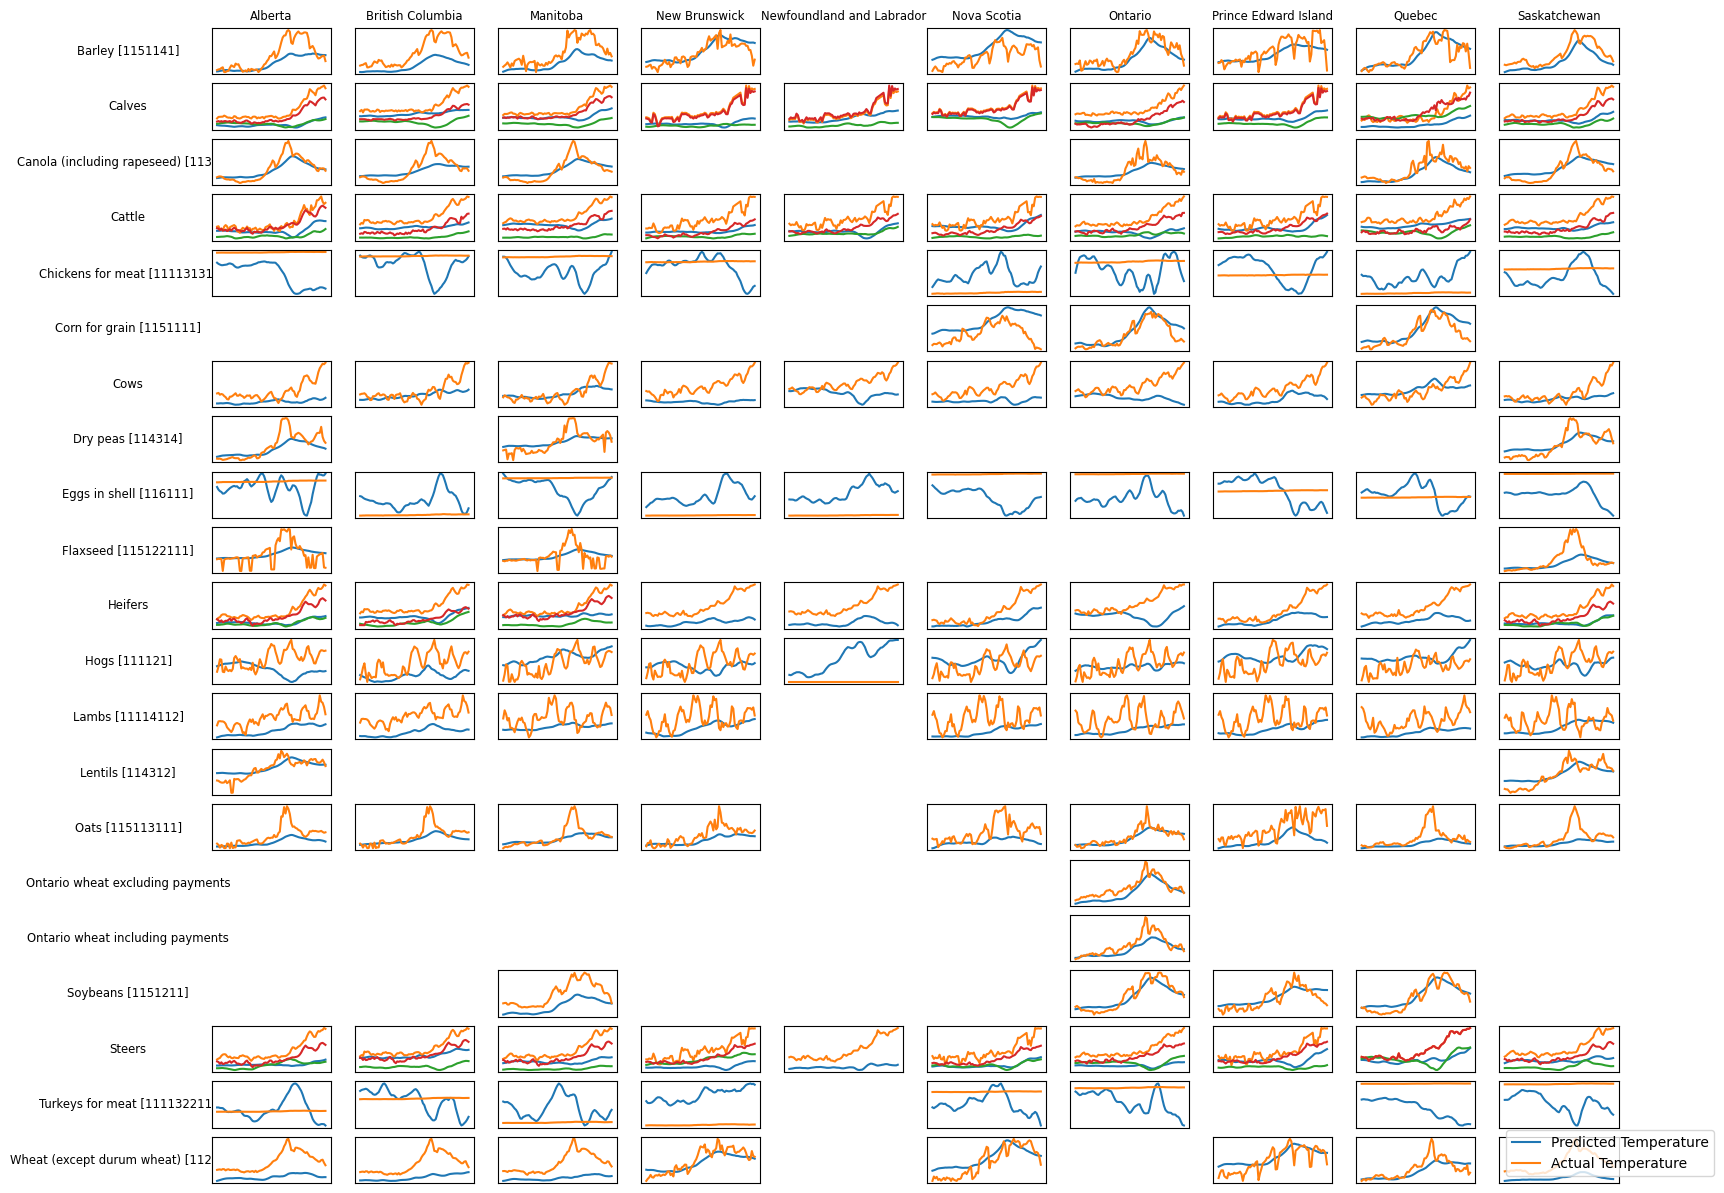

In [161]:
predictions = model.predict(X_test)

# Inverse scale the predictions
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test)

products = np.unique( [c[1] for c in data.columns] )
provinces = np.unique( [c[0] for c in data.columns] )

# Plot the results
import matplotlib.pyplot as plt
#plt.figure(figsize=(21, 15))

fig, axes = plt.subplots(nrows=21, ncols=11, figsize=(20, 15))

for i in range(21):
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    for j in range(0, 11):
        axes[i, j].axis('off')

for i in range(predictions.shape[1]):
    r = np.where(products == data.columns[i][1])[0][0]
    c = np.where(provinces == data.columns[i][0])[0][0] + 1

    axes[r, c].axis('on')

    axes[r, c].plot(predictions[:, i], label='Predicted Temperature')
    axes[r, c].plot(y_test_scaled[:, i], label='Actual Temperature')

    # Optional: Remove the x and y ticks for clarity
    axes[r, c].set_xticks([])
    axes[r, c].set_yticks([])

for j, col in enumerate(provinces):
    axes[0, j+1].set_title(col, size = 'small')

for ax, row in zip(axes[:,0], products):   
    ax.text(0.5, 0.5, row, ha='center', va='center', rotation=0, size='small')
    ax.axis('off')  # Turn off the axis for the label cells

#plt.tight_layout()
plt.legend()
plt.show()

In [131]:
r[0][0]

0

In [79]:
y_test_scaled

array([[198.  , 177.19, 154.25, ..., 138.96, 160.58, 146.97],
       [207.99, 180.56, 156.44, ..., 134.39, 165.74, 143.91],
       [208.45, 175.59, 140.26, ..., 127.93, 174.29, 134.14],
       ...,
       [408.37, 334.77, 273.69, ..., 233.72, 319.41, 245.46],
       [414.73, 335.31, 262.13, ..., 229.08, 322.68, 240.48],
       [397.05, 323.42, 267.94, ..., 223.54, 324.87, 234.75]])

In [119]:

len(provinces)

10

In [115]:
data.columns[0]

('Alberta', 'Barley [1151141]', 'plant', 'None')

In [148]:
X

array([[[0.04661519, 0.06602557, 0.06436145, ..., 0.05081825,
         0.00060514, 0.05308077],
        [0.04687829, 0.07021548, 0.06645969, ..., 0.05053541,
         0.00061171, 0.05497555],
        [0.04749658, 0.0704457 , 0.06488766, ..., 0.05243633,
         0.00061171, 0.05637894],
        ...,
        [0.05149574, 0.07612213, 0.07098506, ..., 0.05123264,
         0.00054594, 0.05568316],
        [0.05082483, 0.07453036, 0.07200458, ..., 0.05315328,
         0.00055252, 0.05653134],
        [0.05001579, 0.06602557, 0.07355031, ..., 0.05476479,
         0.00055252, 0.05706172]],

       [[0.04687829, 0.07021548, 0.06645969, ..., 0.05053541,
         0.00061171, 0.05497555],
        [0.04749658, 0.0704457 , 0.06488766, ..., 0.05243633,
         0.00061171, 0.05637894],
        [0.04882525, 0.07118238, 0.06824221, ..., 0.05398206,
         0.00059856, 0.05640075],
        ...,
        [0.05082483, 0.07453036, 0.07200458, ..., 0.05315328,
         0.00055252, 0.05653134],
        [0.0